In [1]:
import google.datalab.bigquery as bq
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import numpy as np
import sys
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
query="""
SELECT
--callTime,
Weather_precipIntensity,
Wather_temperature,
IF(Weather_precipIntensity>0,"True","False") as badWeather,
FORMAT_TIMESTAMP("%H", callTime) as hour,
--FORMAT_TIMESTAMP("%M", callTime) as minute,
--ROUND(CAST(FORMAT_TIMESTAMP("%M", callTime) as FLOAT64)/60,8) as minuteDecimal,
--ROUND(CAST(FORMAT_TIMESTAMP("%M", callTime) as FLOAT64)/60,8) +  CAST(FORMAT_TIMESTAMP("%H", callTime) AS FLOAT64) as hourDecimal,
--ROUND(4*(ROUND(CAST(FORMAT_TIMESTAMP("%M", callTime) as FLOAT64)/60,8) +  CAST(FORMAT_TIMESTAMP("%H", callTime) AS FLOAT64)),0)/4 as hour,
--CAST(ROUND(CAST(FORMAT_TIMESTAMP("%M", callTime) as FLOAT64)/60) as STRING) as minuteDecimal,
FORMAT_TIMESTAMP("%A", callTime) as dayofweek,
COALESCE(NbEmptyDocks / NULLIF(NbDocks,0), 0) as bikesused,
FARM_FINGERPRINT((CONCAT(CAST(callTime AS STRING),commonName))) as key,
IF(REGEXP_CONTAINS(FORMAT_TIMESTAMP("%A", callTime), 'Saturday|Sunday'),"True","False") as weekend
FROM `tflbikeuse-philipkm.tflbikeuse_dataset.TFLBikeUsageStats`
WHERE
MOD(ABS(FARM_FINGERPRINT((CONCAT(CAST(callTime AS STRING),commonName)))),100)<5 AND--TRAIN
Weather_summary IS NOT NULL
"""
df = bq.Query(query).execute().result().to_dataframe()
df.head()


,Weather_precipIntensity,Wather_temperature,badWeather,hour,dayofweek,bikesused,key,weekend
0,0.0,7.48,False,01,Tuesday,0.620690,-6982458570208423304,False
1,0.0,7.43,False,02,Tuesday,0.609756,8420802398477660301,False
2,0.0,7.48,False,01,Tuesday,0.333333,8277913025494054701,False
3,0.0,7.48,False,01,Tuesday,0.486486,2006230500018064000,False
4,0.0,7.43,False,02,Tuesday,0.184211,6123215890844466004,False


<h2>Benchmarking<h2>

In [50]:
import datetime
df_bm=df
onehot_hour=pd.get_dummies(df_bm['hour'],prefix='hour')
onehot_day=pd.get_dummies(df_bm['dayofweek'])
onehot_badWeather=pd.get_dummies(df_bm['badWeather'],prefix='badWeather')
df_bm=df_bm.join(onehot_hour)
df_bm=df_bm.join(onehot_day)
df_bm=df_bm.join(onehot_badWeather)
df_bm.columns


Index(['Weather_precipIntensity', 'Wather_temperature', 'badWeather', 'hour',
       'dayofweek', 'bikesused', 'key', 'weekend', 'hour_00', 'hour_01',
       'hour_02', 'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07',
       'hour_08', 'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'badWeather_False', 'badWeather_True'],
      dtype='object')

In [51]:
import datetime
df_bm=df
onehot_hour=pd.get_dummies(df_bm['hour'],prefix='hour')
onehot_day=pd.get_dummies(df_bm['dayofweek'])
onehot_badWeather=pd.get_dummies(df_bm['badWeather'],prefix='badWeather')
df_bm=df_bm.join(onehot_hour)
df_bm=df_bm.join(onehot_day)
df_bm=df_bm.join(onehot_badWeather)
df_bm.columns
df_bm_train = df_bm.sample(frac=0.8,random_state=0)
df_bm_valid = df_bm.drop(df_bm_train.index)
FEATURES=["badWeather_False","badWeather_True","hour_00","hour_01","hour_02","hour_03","hour_04","hour_05","hour_06","hour_07","hour_08","hour_09","hour_10","hour_11","hour_12","hour_13","hour_14","hour_15","hour_16","hour_17","hour_18","hour_19","hour_20","hour_21","hour_22","hour_23",'Friday', 'Monday','Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
LABEL="bikesused"

def make_input_fn(df, num_epochs):
  return tf.estimator.inputs.pandas_input_fn(
    x = df,
    y = df[LABEL],
    batch_size = 128,
    #batch_size = 512,
    num_epochs = num_epochs,
    shuffle = True,
    queue_capacity = 1000,
    num_threads = 1
  )

def make_feature_cols():
  input_columns = [tf.feature_column.numeric_column(k) for k in FEATURES]
  return input_columns

print(datetime.datetime.now())
tf.logging.set_verbosity(tf.logging.ERROR)
OUTDIR = 'tfl_pandas_BQ_trained_Lin'
shutil.rmtree(OUTDIR, ignore_errors = True) # start fresh each time
modelLin = tf.estimator.LinearRegressor(
      feature_columns = make_feature_cols(), model_dir = OUTDIR)
modelLin.train(input_fn = make_input_fn(df_bm_train, num_epochs = 1))#500))
print(datetime.datetime.now())

def print_rmse(model, name, df):
  metrics = model.evaluate(input_fn = make_input_fn(df, 1))
  print('RMSE on {} dataset = {}'.format(name, np.sqrt(metrics['average_loss'])))
print_rmse(modelLin, 'validation', df_bm_valid)

2019-04-16 14:30:25.079628
2019-04-16 14:31:01.618058
RMSE on validation dataset = 0.3033185303211212


In [54]:
df_bm_train.columns

Index(['Weather_precipIntensity', 'Wather_temperature', 'badWeather', 'hour',
       'dayofweek', 'bikesused', 'key', 'weekend', 'hour_00', 'hour_01',
       'hour_02', 'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07',
       'hour_08', 'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'badWeather_False', 'badWeather_True'],
      dtype='object')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


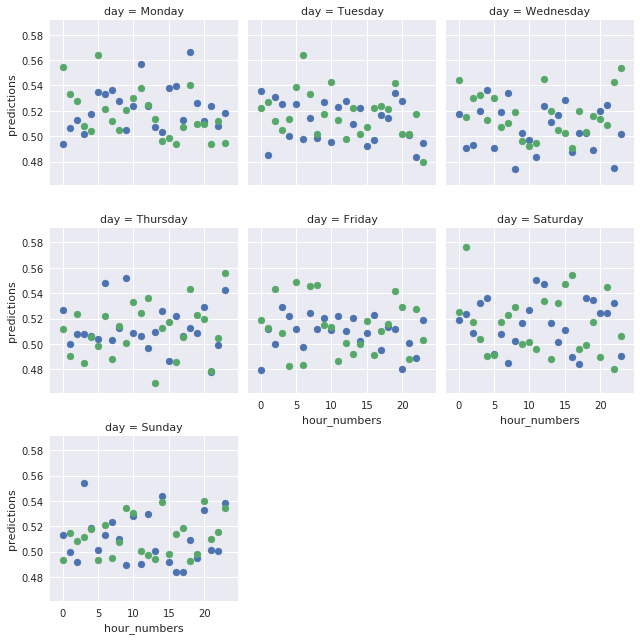

In [149]:
import pandas as pd
import re
day=["Monday"]*48+["Tuesday"]*48+["Wednesday"]*48+["Thursday"]*48+["Friday"]*48+["Saturday"]*48+["Sunday"]*48
bikesused=[0.5]*24*14
hour_numbers=list(range(0, 24,1))*14
hour=['hour_00', 'hour_01',
       'hour_02', 'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07',
       'hour_08', 'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23']*14
badweather=["False"]*24+["True"]*24+["False"]*24+["True"]*24+["False"]*24+["True"]*24+["False"]*24+["True"]*24+["False"]*24+["True"]*24+["False"]*24+["True"]*24+["False"]*24+["True"]*24
input_df=pd.DataFrame(list(zip(hour, badweather,day,bikesused)),columns=['hour', 'badWeather','dayofweek','bikesused'])
onehot_hour=pd.get_dummies(input_df['hour'])
onehot_day=pd.get_dummies(input_df['dayofweek'])
onehot_badWeather=pd.get_dummies(input_df['badWeather'],prefix='badWeather')
input_df=input_df.join(onehot_hour)
input_df=input_df.join(onehot_day)
input_df=input_df.join(onehot_badWeather)
input_df=input_df.drop(['hour','badWeather','dayofweek'],axis=1)
input_df
def get_predictions(model, df):
  return  model.predict(input_fn = make_input_fn(df, 1))
preds=get_predictions(modelLin,input_df)
preds=list(preds)
preds
#preds[0]['predictions'][0]
##type(preds)
input_df['predictions']=[f['predictions'][0] for f in preds]
input_df['hour_numbers']=hour_numbers
input_df['day']=day
input_df['badweather']=badweather
input_df
g = sns.FacetGrid(input_df, col="day",  hue="badweather",col_wrap=3)
g = (g.map(plt.scatter,"hour_numbers", "predictions"))
#sns.lmplot( x="hour_numbers", y="predictions", data=input_df, fit_reg=False)



/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


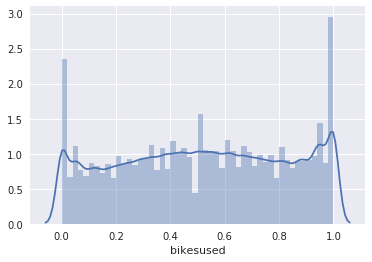

In [136]:
sns.distplot(df['bikesused']);

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


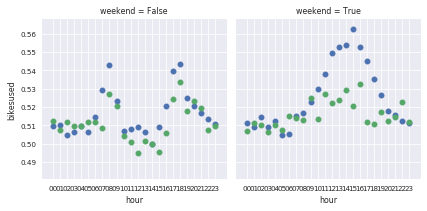

In [22]:
df_goodWeather=df.loc[df['badWeather'] == "False"]
df_badWeather=df.loc[df['badWeather'] == "True"]
df_goodWeather_grouped=df_goodWeather.groupby(["hour"]).mean()
df_badWeather_grouped=df_badWeather.groupby(["hour"]).mean()

df_grouped=df.groupby(["hour","badWeather","weekend"],as_index=False).mean()
df_grouped.head()
#plt.scatter(df_goodWeather_grouped.index,df_goodWeather_grouped["bikesused"])
#plt.scatter(df_badWeather_grouped.index,df_badWeather_grouped["bikesused"])
#plt.show()


#sns.set_context("paper", font_scale=0.9)
g = sns.FacetGrid(df_grouped, col="weekend",  hue="badWeather")
g = (g.map(plt.scatter,"hour", "bikesused"))

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


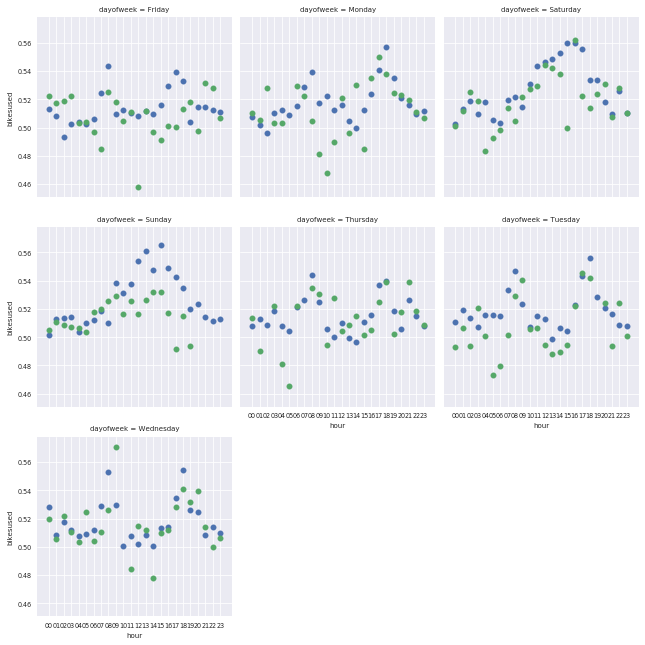

In [16]:
df_goodWeather=df.loc[df['badWeather'] == "False"]
df_badWeather=df.loc[df['badWeather'] == "True"]
df_goodWeather_grouped=df_goodWeather.groupby(["hour"]).mean()
df_badWeather_grouped=df_badWeather.groupby(["hour"]).mean()

df_grouped=df.groupby(["hour","badWeather","dayofweek"],as_index=False).mean()
df_grouped.head()
#plt.scatter(df_goodWeather_grouped.index,df_goodWeather_grouped["bikesused"])
#plt.scatter(df_badWeather_grouped.index,df_badWeather_grouped["bikesused"])
#plt.show()


sns.set_context("paper", font_scale=0.8)
g = sns.FacetGrid(df_grouped, col="dayofweek",col_wrap=3,  hue="badWeather")
g = (g.map(plt.scatter,"hour", "bikesused"))

In [7]:
df_grouped.head()

,Weather_precipIntensity,Wather_temperature,bikesused,key
hour,,,,
00,0.109627,7.317467,0.510149,-5.556682e+15
01,0.133536,7.077979,0.509695,7.764706e+15
02,0.138667,6.822491,0.508003,-2.452185e+16
03,0.055486,6.373035,0.507296,-3.285381e+16
04,0.071333,6.166598,0.510048,1.034278e+16


In [10]:
print("Skewness: %f" % df['bikesused'].skew())
print("Kurtosis: %f" % df['bikesused'].kurt())

Skewness: -0.057651
Kurtosis: -1.151135


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


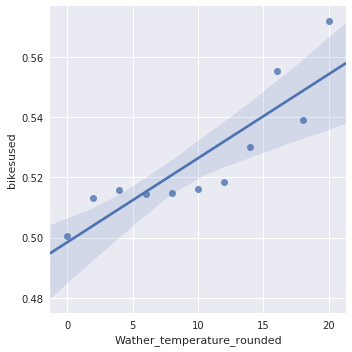

In [137]:
df['Wather_temperature_rounded'] = round(df.Wather_temperature/2)*2
#df['Wather_temperature_rounded']=df['Wather_temperature_rounded']*5
df_groupedTemp=df.groupby(['Wather_temperature_rounded'],as_index=False ).mean()
ax = sns.lmplot(x="Wather_temperature_rounded",y="bikesused", data=df_groupedTemp)


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


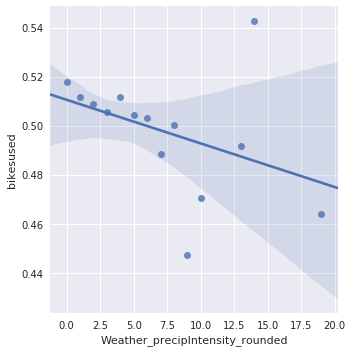

In [128]:

df['Weather_precipIntensity_rounded'] = round(df.Weather_precipIntensity/1)*1
#ax=sns.boxplot(x='Weather_precipIntensity_rounded',y='bikesused',data=df)
df_groupedprep=df.groupby(['Weather_precipIntensity_rounded'],as_index=False ).mean()
#df_groupedprep
###sns.distplot(df_groupedTemp['bikesused
ax = sns.lmplot(x="Weather_precipIntensity_rounded",y="bikesused", data=df_groupedprep)

/usr/local/envs/py3env/lib/python3.5/site-packages/seaborn/categorical.py:450: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


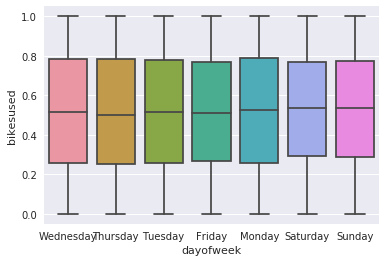

In [145]:
ax=sns.boxplot(x='dayofweek',y='bikesused',data=df)

/usr/local/envs/py3env/lib/python3.5/site-packages/seaborn/categorical.py:450: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


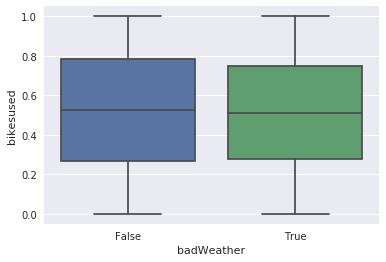

In [146]:
ax=sns.boxplot(x='badWeather',y='bikesused',data=df)

In [154]:
stats.ttest_ind(df.loc[df['badWeather'] == "False"]['bikesused'],df.loc[df['badWeather'] == "True"]['bikesused'],equal_var = False)

Ttest_indResult(statistic=7.692445920741546, pvalue=1.448888640438602e-14)

In [155]:
stats.ttest_ind(df.loc[df['weekend'] == "False"]['bikesused'],df.loc[df['weekend'] == "True"]['bikesused'],equal_var = False)

Ttest_indResult(statistic=-13.012477239234501, pvalue=1.0531155055968496e-38)

/usr/local/envs/py3env/lib/python3.5/site-packages/seaborn/categorical.py:450: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)
/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


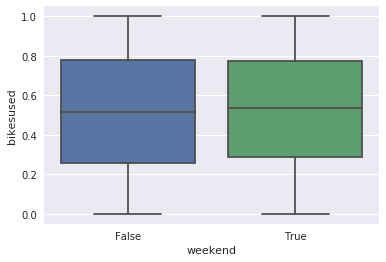

In [147]:
ax=sns.boxplot(x='weekend',y='bikesused',data=df)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


ValueError: color kwarg must have one color per dataset

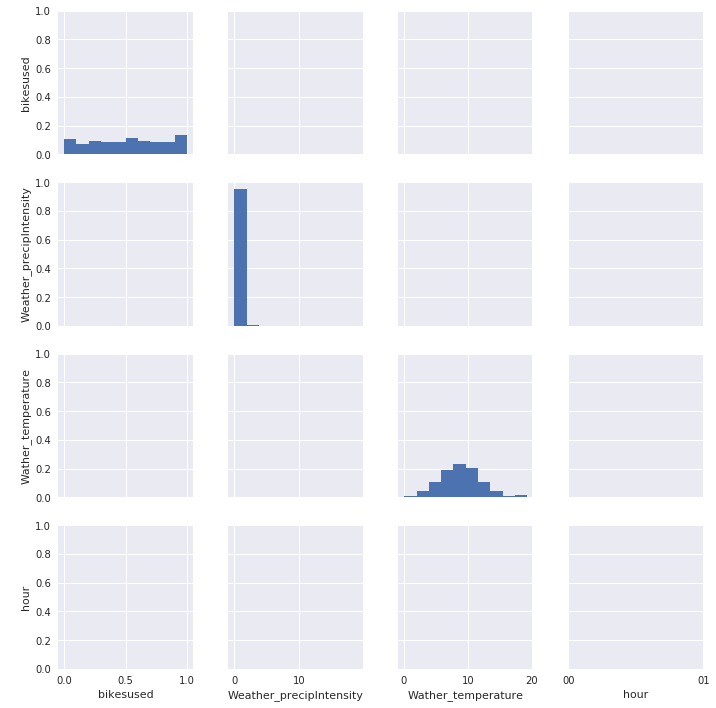

In [150]:
#scatterplot
sns.set()
cols = ['bikesused', 'dayofweek', 'weekend', 'Weather_precipIntensity', 'Wather_temperature', 'hour']
sns.pairplot(df[cols], size = 2.5)
plt.show();

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


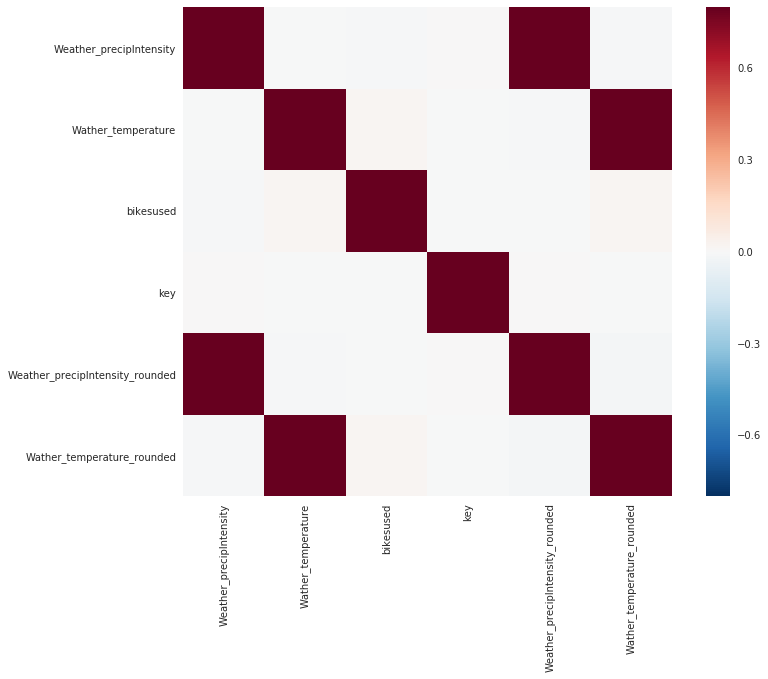

In [149]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

In [41]:
query="""
SELECT
AVG(COALESCE(NbEmptyDocks / NULLIF(NbDocks,0), 0)) as bikesused,
FORMAT_TIMESTAMP("%H", callTime) as hour,
--FORMAT_TIMESTAMP("%A", callTime) as dayofweek,
IF(REGEXP_CONTAINS(Weather_summary, '(?i)rain|snow|sleet|hail|thunderstorm|tornado'),1,0) as badWeather,
IF(REGEXP_CONTAINS(FORMAT_TIMESTAMP("%A", callTime), 'Saturday|Sunday'),1,0) as weekend
FROM `tflbikeuse-philipkm.tflbikeuse_dataset.TFLBikeUsageStats`
WHERE 
Weather_summary IS NOT NULL
--group by dayofweek,weekend,hour,badWeather
group by weekend,hour,badWeather
"""
df_avg = bq.Query(query).execute().result().to_dataframe()
df_avg.head()

,bikesused,hour,badWeather,weekend
0,0.513323,08,1,1
1,0.499240,12,1,0
2,0.546032,17,0,1
3,0.510025,02,0,1
4,0.512913,00,0,1


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


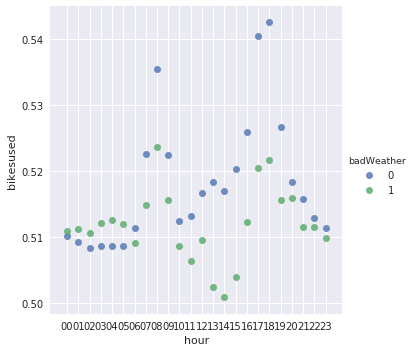

In [33]:
sns.lmplot( x="hour", y="bikesused", data=df_avg, fit_reg=False, hue='badWeather')

In [148]:
g = sns.FacetGrid(df_avg, col="weekend",  hue="badWeather")
g = (g.map(plt.scatter,"hour", "bikesused"))

NameError: name 'df_avg' is not defined